In [1]:
import sys
print(sys.version)

3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]


In [2]:
!pip install torch torchvision torchaudio

In [3]:
import torch
print("PyTorch verisio:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

PyTorch verisio: 2.9.1+cpu
CUDA available: False


In [4]:
!pip install opencv-python matplotlib numpy scikit-learn

In [5]:
import torch

x = torch.rand(3, 3)
y = torch.rand(3, 3)
z = x + y

print(z)

tensor([[1.0945, 1.1214, 1.6362],
        [0.5796, 0.9366, 0.3502],
        [0.9518, 1.1501, 0.5631]])


In [6]:
import sys
print(sys.executable)

C:\Users\hlogi\anaconda3\python.exe


In [7]:
import os
import cv2
import torch
from torch.utils.data import Dataset
from torchvision import transforms

In [8]:
# Define LivenessDataset
class LivenessDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []

        classes = ["real", "spoof"]

        for label in range(len(classes)):
            class_name = classes[label]
            class_path = os.path.join(root_dir, class_name)

            for img_name in os.listdir(class_path):
                if img_name.lower().endswith((".jpg", ".png", ".jpeg")):
                    self.images.append(os.path.join(class_path, img_name))
                    self.labels.append(label)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            image = self.transform(image)

        return image, label

In [9]:
# Defin transform
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

In [10]:
# Load the Dataset
dataset = LivenessDataset(root_dir=r"C:\Users\hlogi\Documents\FaceLiveness", transform=transform)

print("Total images loaded:", len(dataset))

Total images loaded: 8


In [11]:
import os

print("Real images:", os.listdir(r"C:\Users\hlogi\Documents\FaceLiveness\real"))
print("Spoof images:", os.listdir(r"C:\Users\hlogi\Documents\FaceLiveness\spoof"))


Real images: ['real1.jpg', 'real2.jpg', 'real3.jpg', 'real4.jpg']
Spoof images: ['spoof1.jpg', 'spoof2.jpg', 'spoof3.jpg', 'spoof4.jpg']


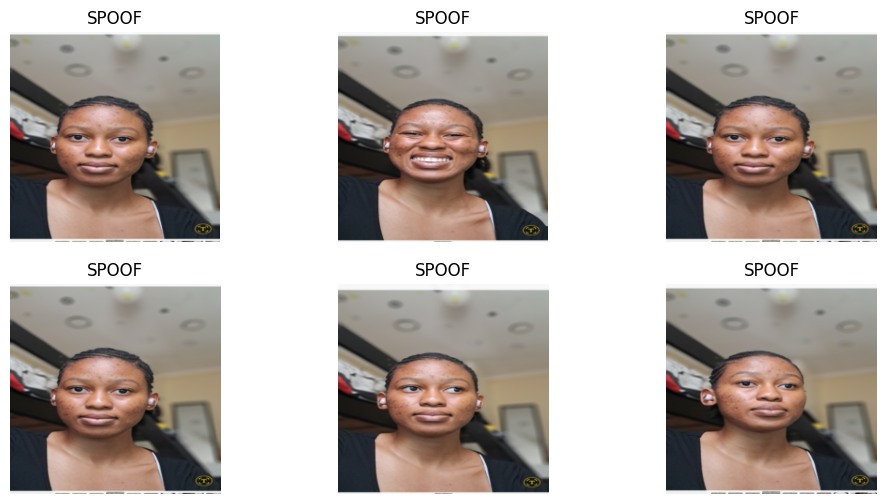

In [12]:
# Visualize our images
import matplotlib.pyplot as plt
import random

def show_samples(dataset, num_samples=6):
    plt.figure(figsize=(12, 6))

    for i in range(num_samples):
        idx = random.randint(0, len(dataset) - 1)
        image, label = dataset[idx]

        image = image.permute(1, 2, 0)

        image = image * 0.5 + 0.5

        plt.subplot(2, 3, i + 1)
        plt.imshow(image)
        plt.title("REAL" if label ==0 else "SPOOF")
        plt.axis("off")

    plt.show()

show_samples(dataset)

In [13]:
# Defining the CNN Model
import torch
import torch.nn as nn
import torch.nn.functional as F

class LivenessCNN(nn.Module):
    def __init__(self):
        super(LivenessCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(64 *28 *28, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))

        return x

In [14]:
# Test model
model = LivenessCNN()

sample_image, _ = dataset[0]
sample_image = sample_image.unsqueeze(0)

output = model(sample_image)
print("Model output:", output)

Model output: tensor([[0.5195]], grad_fn=<SigmoidBackward0>)


In [15]:
# Train model
from torch.utils.data import DataLoader

train_loader = DataLoader(
    dataset,
    batch_size=2,
    shuffle=True
)

print("Batches ready")

Batches ready


In [16]:
import torch.optim as optim

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [17]:
#Training loop
epochs = 10

for epoch in range(epochs):
    running_loss = 0.0

    for images, labels in train_loader:
        labels = labels.float().unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

print(f"Epoch {epochs}, Loss: {running_loss: .4f}")

Epoch 10, Loss:  0.0006


In [18]:
# Test predictions
model.eval()

with torch.no_grad():
    for img, label in dataset:
        output = model(img.unsqueeze(0))
        print("Prediction:", output.item(), "| Actual:", label)

Prediction: 5.550718015001621e-06 | Actual: 0
Prediction: 2.771385697997175e-05 | Actual: 0
Prediction: 4.520256879914086e-06 | Actual: 0
Prediction: 1.1319027635181556e-06 | Actual: 0
Prediction: 1.0 | Actual: 1
Prediction: 0.9999991655349731 | Actual: 1
Prediction: 1.0 | Actual: 1
Prediction: 0.9999986886978149 | Actual: 1
